In [1]:
%%capture
# 그래프에서 한글이 깨지지 않게 폰트 설치..
# *맨처음 실행 후 세션 다시 시작해야 반영됨!!
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install gdown
!pip install einops
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [4]:
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import LambdaLR
from kobert_tokenizer import KoBERTTokenizer
import pandas as pd
from tqdm import tqdm
import math, random
from einops import rearrange
import time

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [5]:
# for random seed
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(random_seed)

In [6]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
pad_idx = tokenizer.pad_token_id
print("pad_idx = ", pad_idx)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


pad_idx =  1


## 하이퍼파라미터 조정

In [7]:
BATCH_SIZE = 64 # GPT-1 논문의 값, Fine-tune 시에는 32 사용, GPT-2 에선 512 사용
LAMBDA = 0 # GPT-1 에선 0.01, l2-Regularization를 위한 hyperparam.
EPOCH = 15 # GPT-1 에선 100 Epoch, Fine-tune 시에는 3 사용
max_len = 100
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx) # pad token 이 출력 나와야하는 시점의 loss는 무시 (즉, label이 <pad> 일 때는 무시)

warmup_steps = 2000 # GPT-1 논문의 값, Fine-tune 시에는 total_steps의 0.2% 만 warmup
LR_peak = 2.5e-4 # GPT-1 논문의 값, Fine-tune 시에는 6.25e-5
total_steps = EPOCH * math.ceil(97000/BATCH_SIZE) # 97000: 문장 데이터 수
def lr_lambda(step): # LambdaLR 쓰면 Custom 스케쥴러처럼 일일히 step+=1 할 필요 없음! step 만 입력 받으면 되는 스케쥴러라면 LambdaLR 사용하면 됨
    return min(step / warmup_steps, (0.5 * (1 + math.cos(math.pi * (step - warmup_steps) / (total_steps - warmup_steps))))) # 이게 LR_peak 에 곱해짐

new_model_train = False
hyuk_model_use = True # 여러분만의 모델 만들어서 사용하고 싶다면 False로
if hyuk_model_use:
    !gdown https://drive.google.com/uc?id=1u4-QhuKcHwDifff5eHLhuZmfJ52c3tkN -O GPT_small.pt
    !gdown https://drive.google.com/uc?id=1-3uZGsxgaoll8LNzDBNGjhCYRYorRdRq -O GPT_small_history.pt
    save_model_path = 'GPT_small.pt'
    save_history_path = 'GPT_small_history.pt'
else:
    save_model_path = '/content/drive/MyDrive/Colab Notebooks/results/GPT_small2.pt'
    save_history_path = '/content/drive/MyDrive/Colab Notebooks/results/GPT_small2_history.pt'

Downloading...
From (original): https://drive.google.com/uc?id=1u4-QhuKcHwDifff5eHLhuZmfJ52c3tkN
From (redirected): https://drive.google.com/uc?id=1u4-QhuKcHwDifff5eHLhuZmfJ52c3tkN&confirm=t&uuid=b53c01c4-d089-4b63-b8fa-b2a8cae5b118
To: /content/GPT_small.pt
100% 1.17G/1.17G [00:17<00:00, 66.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-3uZGsxgaoll8LNzDBNGjhCYRYorRdRq
To: /content/GPT_small_history.pt
100% 1.23k/1.23k [00:00<00:00, 5.72MB/s]


In [8]:
# GPT-3 (1750억개 파라미터)
# n_layers = 96
# d_model = 12288
# d_ff = 49152 # d_model 의 네 배
# n_heads = 96
# drop_p = 0.1

# 실험에서 사용할 작은 GPT (drop_p 이외엔 GPT-1 과 일치)
n_layers = 12
d_model = 768
d_ff = d_model * 4
n_heads = 12
drop_p = 0.25 # GPT-1 에서는 0.1

In [9]:
print(tokenizer.get_vocab())
vocab_size = tokenizer.vocab_size
print(vocab_size)

print(tokenizer.tokenize("신발이 참 예쁘네요!"))
print(tokenizer.encode('신발이 참 예쁘네요!')) # string to index
print(tokenizer.decode([2155]))

{'[UNK]': 0, '[PAD]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, '!': 5, "!'": 6, '!”': 7, '"': 8, '#': 9, '$': 10, '%': 11, '%)': 12, '&': 13, '&#34;': 14, "'": 15, "'(": 16, "',": 17, '(': 18, '(0': 19, '(1': 20, '(10': 21, '(12': 22, '(15': 23, '(17': 24, '(18': 25, '(19': 26, '(2': 27, '(20': 28, '(23': 29, '(24': 30, '(25': 31, '(3': 32, '(4': 33, '(5': 34, '(6': 35, '(7': 36, '(8': 37, '(9': 38, '(?)': 39, ')': 40, ")'": 41, '),': 42, ')’': 43, '*': 44, '+': 45, ',': 46, '-': 47, '----------------': 48, '-1': 49, '-2': 50, '-20': 51, '-3': 52, '-4': 53, '.': 54, '...': 55, '..."': 56, "...'": 57, '...”': 58, '/': 59, '0': 60, '0%': 61, '0%)': 62, '0.0': 63, '0.00': 64, '0.1': 65, '0.1%': 66, '0.2%': 67, '0.3': 68, '0.3%': 69, '0.4%': 70, '0.5': 71, '0.5%': 72, '0.6': 73, '0.6%': 74, '0.7': 75, '0.7%': 76, '0.8': 77, '0.8%': 78, '00': 79, '000.0': 80, '00000': 81, '01': 82, '02': 83, '02-': 84, '03': 85, '04': 86, '05': 87, '06': 88, '07': 89, '08': 90, '09': 91, '0:00:00': 92, '1': 

## DS, DL 생성 & 테스트

In [10]:
# data 다운
%%capture
# https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=126 에서 받을 수 있어요
!gdown https://drive.google.com/uc?id=14lAjaR2dRp5p5kEsm5GnwNM9KH-VgoOq -O 대화체.xlsx
data = pd.read_excel('대화체.xlsx')

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data.loc[idx, '원문']

custom_DS = CustomDataset(data)

train_DS, val_DS, test_DS = torch.utils.data.random_split(custom_DS, [97000, 2000, 1000])

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

97000
2000
1000


In [12]:
# train_DL 테스트
for texts in train_DL:

    print(texts) # __getitem__ return이 문자열이면 default_collate 함수가 그냥 리스트로 묶어서 줌. (ndarray, int 이런 애들은 텐서로 바꿔서 묶어서 줌)
    print(len(texts))

    texts = [s + ' [SEP]'for s in texts] # [SEP]을 <eos>로 사용하기 위함 (<eos>가 따로 토크나이저에 없음)
    x_batch = tokenizer(texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt', add_special_tokens = False).input_ids # pt: pytorch tensor로 변환
    # add_special_tokens = True (default)면 첫 토큰에 [CLS], 마지막 토큰에 [SEP]이 붙어 나옴

    print(x_batch[:2])
    print(x_batch.shape)
    print(x_batch[5,:-1]) # 입력
    print(x_batch[5,1:]) # label

    break

['아메리카노 1잔과 샌드위치 1개를 내일 아침 제 방으로 가져다주세요.', '아닙니다, 바로 다음에 나올 음식을 손님께 드리도록 할게요.', '2인분 추가 주문하면 음식이 나오는 데 얼마나 걸릴까요?', '일러스트 프로그램은 추가로 설치를 하셔야 하는데, 30분 정도 시간이 걸릴 것입니다.', '여기 이 부분이요, 아까 설명해주신 거랑 좀 다른 것 같은데요?', '그 제품은 품절되어 현재 남은 물량이 없습니다.', '새 상품과 기존에 받으셨던 상품의 맞교환으로 진행해드리겠습니다.', '그러게, 심지어 더치페이를 얼마를 해야 하는지 계산도 해줘.', '판매하는 핸드폰 케이스 종류를 늘려야 할인지도 모르겠어요.', '응, 식구들도 일찍 집에서 나가서 나를 깨워줄 사람이 없었어.', '하지만 꼭 인기 있는 주인공만 출연하는 것 같아.', '혹시 기내에서 카드 결제도 가능한가요?', '이 수박은 먹을 수도 없으니 환불 부탁드립니다.', '생각보다 음료가 너무 써서 그런데 시럽을 좀 추가할 수 있을까요?', '새로 계약하기로 했던 거 어떻게 되어가고 있어요?', '신경이 많이 쓰여서 웃을 때도 크게 안 웃거든요.', '마음에 드셨다니 다행이네요, 20분 정도 걸리는데 괜찮으세요?', '지금 퇴근하는 시간이라 차가 많이 막히지 않을까?', '그러면 저희 방으로 치킨을 시켜주실 수 있나요?', '한 팩에 물티슈가 100매 정도 들어 있습니다.', '체크인 시간은 11시까지인데, 혹시 언제 오세요?', '11일은 저희 쪽에서 힘들 것 같으니, 12일로 할 수 있을까요?', '장대리, 이번 우수실적 명단에 포함된 것 축하해.', '이 절에 가려면 버스를 타고 한 시간을 가야 해.', '다른 지점보다 훨씬 저렴하네요. 오늘 아무 때나 방문해도 될까요?', '몇 년간 꾸준히 SNS 활동을 했으며 이전에 상품 리뷰를 작성한 경험이 있는 사람들을 우선순위로 뽑았습니다.', '그러게, 아까 길 물어봤을 때 거기서 5분만 걸어가면 보인다고 했는데 말이지.', '요즘은 로봇 청소기보다 

## 모델 구현

In [13]:
class MHA(nn.Module):
    def __init__(self, d_model, n_heads, drop_p):
        super().__init__()

        self.n_heads = n_heads

        self.fc_q = nn.Linear(d_model, d_model) # 차 or 개x차 or 개x개x차 로 입력해줘야
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(drop_p) # GPT-1 논문에서 어텐션 드롭아웃 적용
        self.scale = torch.sqrt(torch.tensor(d_model / n_heads))

    def forward(self, x, mask=None):
        Q = self.fc_q(x)  # 개단차
        K = self.fc_k(x)
        V = self.fc_v(x)

        Q = rearrange(Q, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads) # 개단차 -> 개헤단차
        K = rearrange(K, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads)
        V = rearrange(V, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads)

        attention_score = Q @ K.transpose(-2,-1) / self.scale # 개헤단단

        if mask is not None:
            attention_score[mask] = -1e10
        attention_weights = torch.softmax(attention_score, dim=-1) # 개헤단단

        attention_weights = self.dropout(attention_weights) # 개헤단단

        attention = attention_weights @ V # 개헤단차

        x = rearrange(attention, '개 헤 단 차 -> 개 단 (헤 차)') # 개헤단차 -> 개단차
        x = self.fc_o(x)  # 개단차

        return x, attention_weights

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(d_model, d_ff),
                                    nn.GELU(),
                                    nn.Dropout(drop_p), # 논문에는 명시되어 있지 않지만.. overfitting 취약한 부분이라
                                    nn.Linear(d_ff, d_model))

    def forward(self, x):
        x = self.linear(x)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten_LN = nn.LayerNorm(d_model)
        self.self_atten = MHA(d_model, n_heads, drop_p)

        self.FF_LN = nn.LayerNorm(d_model)
        self.FF = FeedForward(d_model, d_ff, drop_p)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, dec_mask):

        residual = self.self_atten_LN(x)
        residual, atten_dec = self.self_atten(residual, dec_mask)
        residual = self.dropout(residual) # 원랜 attn -> drop -> add -> norm 이었는데 norm -> attn -> drop -> add 순으로 변경 (GPT-2 에서)
        x = x + residual

        residual = self.FF_LN(x)
        residual = self.FF(residual)
        residual = self.dropout(residual)
        x = x + residual

        return x, atten_dec

class Decoder(nn.Module):
    def __init__(self, vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.input_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([DecoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])

        self.LN_out = nn.LayerNorm(d_model)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x, dec_mask, atten_map_save = False): # x.shape = 개단, enc_out.shape = 개단차, dec_mask.shape = 개헤단단

        pos = torch.arange(x.shape[1]).expand_as(x).to(DEVICE) # 개단

        x = self.input_embedding(x) + self.pos_embedding(pos) # 개단차
        x = self.dropout(x)

        atten_decs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_dec = layer(x, dec_mask)
            if atten_map_save is True:
                atten_decs = torch.cat([atten_decs , atten_dec[0].unsqueeze(0)], dim=0) # 층헤단단 ㅋ

        x = self.LN_out(x) # pre-acrivation 이기 때문에 fc_out 전에 (CNN 에서는 GAP-fc => BN-relu-GAP-fc 로 추가했었음)
        x = self.fc_out(x) # activation 없이 바로 fc_out 통과시키더라 (https://github.com/graykode/gpt-2-Pytorch/blob/master/GPT2/model.py#L205 참고)

        return x, atten_decs

class GPT(nn.Module):
    def __init__(self, vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.decoder = Decoder(vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p)

        self.n_heads = n_heads

        # 초기화 기법은 GPT-2 참고해서 만듦
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.02) # GPT-1 논문에서의 초기화
                m.weight.data *= 1/torch.sqrt(torch.tensor(n_layers*2)) # 이건 GPT-2 논문에서 변형한 초기화 (residual 에 1/sqrt(N) 곱하기, N:residual block 총 개수)
                # 더 0 근처로 학습되게 해서 더 "톡!"을 살짝만 하게
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=0.02) # 임베딩 레이어는 residual이 아니라서 이것만

        nn.init.normal_(self.decoder.fc_out.weight, mean=0, std=0.02) # 얘는 residual이 아니기 때문에 원래 초기화대로

    def make_dec_mask(self, x): # x.shape = 개단

        future_mask = torch.tril(torch.ones(x.shape[0], self.n_heads, x.shape[1], x.shape[1]))==0 # 개헤단단
        """ future mask
        F T T T T
        F F T T T
        F F F T T
        F F F F T
        F F F F F
        """
        dec_mask = future_mask # dec_mask.shape = 개헤단단 # 문장 중간에 pad가 껴있지 않는 이상 pad mask는 안해도 됨!
        return dec_mask

    def forward(self, x, atten_map_save = False):

        dec_mask = self.make_dec_mask(x)
        out, atten_decs = self.decoder(x, dec_mask, atten_map_save = atten_map_save)

        return out, atten_decs

In [14]:
Q = torch.randn(1, 4, 6) # 개단차
print(Q)

Q = rearrange(Q, '개 단 (헤 차) -> 개 헤 단 차', 헤 = 3) # 개단차 -> 개헤단차
# 주의! (차 헤) 로 해보면 또 다름. 차원의 수 6을 헤드의 수 3으로 쪼개는 것이므로 (헤 차) 가 맞다
print(Q)
print(Q.shape)

x = rearrange(Q, '개 헤 단 차 -> 개 단 (헤 차)') # 개헤단차 -> 개단차,
print(x)
print(x.shape)

tensor([[[ 0.2595, -0.4927, -0.4737, -0.2074, -1.9427, -1.7322],
         [-0.5939, -1.1785, -0.7656, -1.9260, -0.8876, -0.6519],
         [ 0.1413, -1.7858,  0.2259, -0.0683, -0.4737, -1.9399],
         [-1.4287, -0.6150,  0.4548,  0.8434,  1.2168, -0.7239]]])
tensor([[[[ 0.2595, -0.4927],
          [-0.5939, -1.1785],
          [ 0.1413, -1.7858],
          [-1.4287, -0.6150]],

         [[-0.4737, -0.2074],
          [-0.7656, -1.9260],
          [ 0.2259, -0.0683],
          [ 0.4548,  0.8434]],

         [[-1.9427, -1.7322],
          [-0.8876, -0.6519],
          [-0.4737, -1.9399],
          [ 1.2168, -0.7239]]]])
torch.Size([1, 3, 4, 2])
tensor([[[ 0.2595, -0.4927, -0.4737, -0.2074, -1.9427, -1.7322],
         [-0.5939, -1.1785, -0.7656, -1.9260, -0.8876, -0.6519],
         [ 0.1413, -1.7858,  0.2259, -0.0683, -0.4737, -1.9399],
         [-1.4287, -0.6150,  0.4548,  0.8434,  1.2168, -0.7239]]])
torch.Size([1, 4, 6])


## 모델 생성

In [17]:
model = GPT(vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p).to(DEVICE)

x = torch.tensor([[2,5,4,4,3,1,1],[2,9,6,7,3,1,1]]).to(DEVICE)
print(x.shape)

model.eval()
with torch.no_grad():
    x = model(x[:,:-1])[0]
print(x.shape)

torch.Size([2, 7])
torch.Size([2, 6, 8002])


## Train, Test, loss_epoch 함수

In [19]:
def Train(model, train_DL, val_DL, criterion, optimizer, scheduler = None):
    loss_history = {"train": [], "val": []}
    best_loss = 9999
    for ep in range(EPOCH):
        epoch_start = time.time()

        model.train() # train mode로 전환
        train_loss = loss_epoch(model, train_DL, criterion, optimizer = optimizer, scheduler = scheduler)
        loss_history["train"] += [train_loss]

        model.eval() # test mode로 전환
        with torch.no_grad():
            val_loss = loss_epoch(model, val_DL, criterion)
            loss_history["val"] += [val_loss]
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({"model": model,
                            "ep": ep,
                            "optimizer": optimizer,
                            "scheduler": scheduler,}, save_model_path)
        # print loss
        print(f"Epoch {ep+1}: train loss: {train_loss:.5f}   val loss: {val_loss:.5f}   current_LR: {optimizer.param_groups[0]['lr']:.8f}   time: {time.time()-epoch_start:.0f} s")
        print("-" * 20)

    torch.save({"loss_history": loss_history,
                "EPOCH": EPOCH,
                "BATCH_SIZE": BATCH_SIZE}, save_history_path)

def Test(model, test_DL, criterion):
    model.eval() # test mode로 전환
    with torch.no_grad():
        test_loss = loss_epoch(model, test_DL, criterion)
    print(f"Test loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}")

def loss_epoch(model, DL, criterion, optimizer = None, scheduler = None):
    N = len(DL.dataset) # the number of data

    rloss=0
    for texts in tqdm(DL, leave=False):
        texts = [s + ' [SEP]'for s in texts]
        x_batch = tokenizer(texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt', add_special_tokens = False).input_ids.to(DEVICE)
        # inference
        y_hat = model(x_batch[:,:-1])[0] # 모델 통과 시킬 땐 마지막 토큰은 제외!
        # y_hat.shape = 개단차 즉, 훈련 땐 문장이 한번에 튀어나옴
        # loss
        loss = criterion(y_hat.permute(0,2,1), x_batch[:,1:]) # loss 계산 시엔 첫 토큰은 제외!
        # update
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        # loss accumulation
        loss_b = loss.item() * x_batch.shape[0]
        rloss += loss_b
    loss_e = rloss/N
    return loss_e

def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

def plot_scheduler(optimizer, scheduler, total_steps): # LR curve 보기
    lr_history = []
    steps = range(1, total_steps)

    for _ in steps:
        lr_history += [optimizer.param_groups[0]['lr']]
        scheduler.step()

    plt.figure()
    plt.plot(steps, lr_history, 'b', linewidth=2, label="Learning Rate")
    plt.ylim([-0.1*max(lr_history), 1.2*max(lr_history)])
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.grid()
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


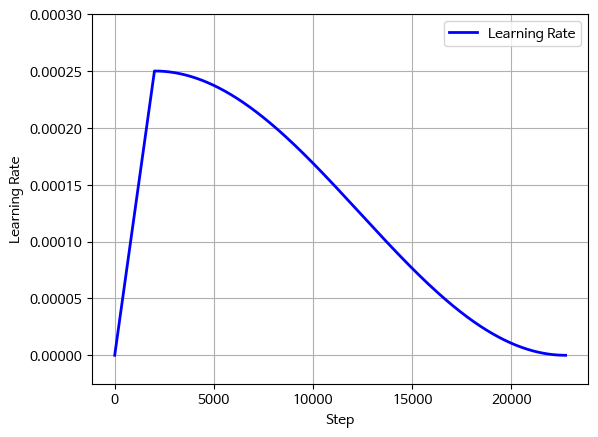

In [20]:
optimizer = optim.AdamW(nn.Linear(1, 1).parameters(), lr=LR_peak)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
plot_scheduler(optimizer = optimizer, scheduler = scheduler, total_steps = total_steps)

## 모델 학습

In [21]:
if new_model_train:
    params = [p for p in model.parameters() if p.requires_grad] # 사전 학습된 layer를 사용할 경우를 대비
    optimizer = optim.AdamW(params, lr=LR_peak, weight_decay=LAMBDA) # GPT-1 논문에서 AdamW를 사용했음
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

    Train(model, train_DL, val_DL, criterion, optimizer, scheduler)

## 로드 모델

In [22]:
loaded = torch.load(save_model_path, map_location=DEVICE, weights_only=False)
load_model = loaded["model"]
ep = loaded["ep"]
optimizer = loaded["optimizer"]

loaded = torch.load(save_history_path, map_location=DEVICE)
loss_history = loaded["loss_history"]

print(ep)
print(optimizer)

12
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.00025
    lr: 1.2953088643299582e-05
    maximize: False
    weight_decay: 0
)


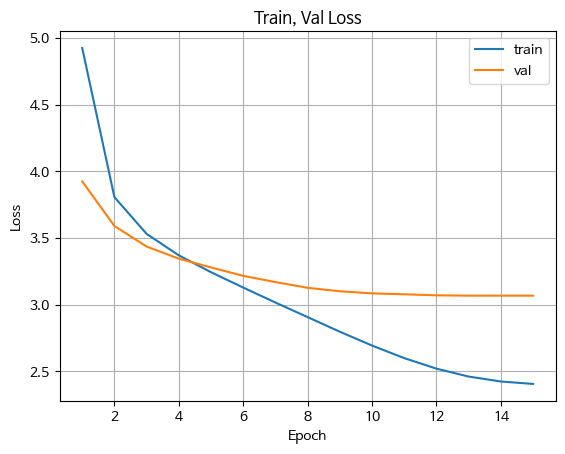

In [ ]:
plt.figure()
plt.plot(range(1,EPOCH+1),loss_history["train"], label="train")
plt.plot(range(1,EPOCH+1),loss_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.grid()
plt.legend()

In [ ]:
Test(load_model, test_DL, criterion)
count_params(load_model)

Test loss: 3.090 | Test PPL: 21.969


97431874

## Next Token Prediction 함수, 어텐션 map 그리는 함수

In [24]:
def generate(model, src_text, atten_map_save = False):
    model.eval()
    with torch.no_grad():
        pred = tokenizer.encode(src_text, return_tensors='pt', add_special_tokens=False).to(DEVICE) # 1x단
        init_length = pred.shape[1]

        for _ in range(max_len-init_length):
            out, atten_decs = model(pred, atten_map_save = atten_map_save)
            # out.shape = (개=1,단,차)

            pred_word = out[:,-1,:].argmax(dim=1).unsqueeze(0) # 마지막 단어에 대해 argmax해서 prediction 하고 shape = (1,1)로
            pred = torch.cat([pred, pred_word], dim=1) # 1x(단+1) (단이 하나 늘어남)

            if tokenizer.decode(pred_word.item()) == '[SEP]':
                break

        pred_text = tokenizer.decode(pred[0])

    return pred_text, atten_decs

def show_attention(atten, Query, Key, n):
    atten = atten.cpu()

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[atten.shape[3]*1.5,atten.shape[2]])
    for i in range(3):
        ax[i].set_yticks(range(atten.shape[2]))
        ax[i].set_yticklabels(Query, rotation=45)
        ax[i].set_xticks(range(atten.shape[3]))
        ax[i].set_xticklabels(Key, rotation=60)
        ax[i].imshow(atten[n-1][i], cmap='bone') # n 번째 layer, 앞 세 개의 헤드만 plot
        # ax[i].xaxis.tick_top()  # x축 레이블을 위쪽으로 이동

In [43]:
# 생성해보기
# src_text = "다시 확인해봐도 아예 켜지지 않네요. 출장 수리 가능"
# src_text = "여기 전에 와 본"
# src_text = "제가 창고 확인해보고 다시"
# src_text = "커피 맛있더라. 내일은"
# src_text = "대학원을"
# src_text = "배고프니까"
# src_text = "졸리면"

# src_text = "정말 기대되네요. 내일 회식에는"
src_text = "정말 죄송합니다. 내일 회식에는"
# src_text = "일도 열심히 했으니 우리 오늘 회"
print(f"입력: {src_text}")

pred_text, atten_decs = generate(load_model, src_text, atten_map_save = True)
print(f"생성된 문장: {pred_text}")

입력: 정말 죄송합니다. 내일 회식에는
생성된 문장: 정말 죄송합니다. 내일 회식에는 참석하지 못할 것 같아요.[SEP]


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


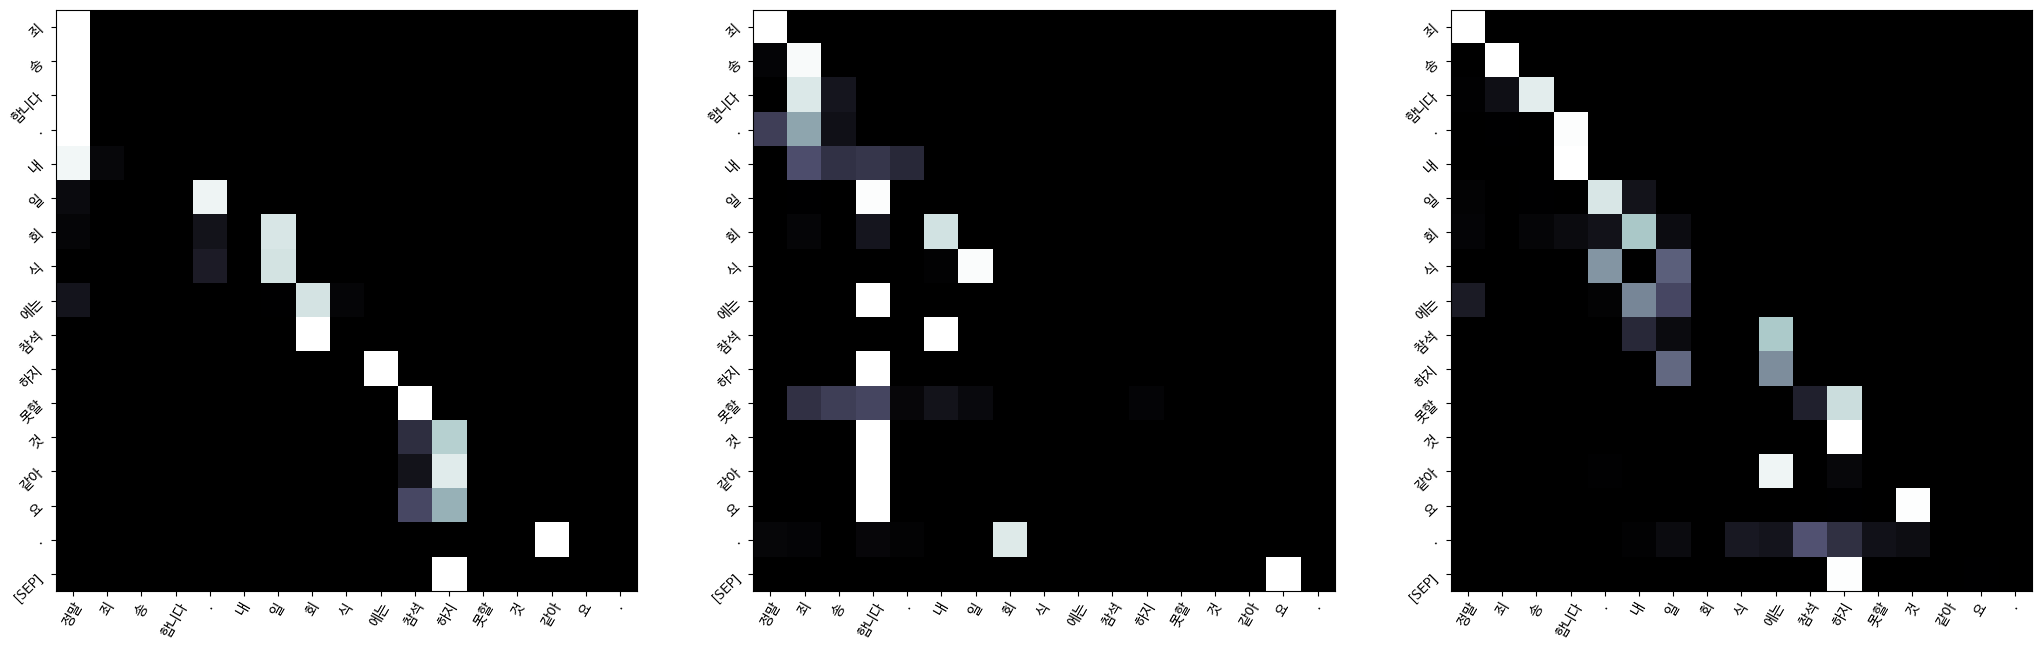

In [51]:
dec_tokens = tokenizer.tokenize(pred_text)
dec_input = dec_tokens[:-1] # 디코더 입력으로 들어가는 문장(sos, eos는 없고)
dec_output = dec_tokens[1:] # 디코더 출력으로 나간 문장

show_attention(atten_decs, dec_output, dec_input, n = 6)
# 0: "이 단어가 나오게끔 뭘 주목했느냐" 로 해석해줘야 함 (ytick에 들어가는 단어가 아닌 예측한 단어를 썼기 때문)

# 1: '있을'이 핵심! 근데 뭘 보고 '있을'라고 예측? '회', '.', '할', '수'... 왜 '기대'는 없을까?
#    self-attention은 value vector간의 weight sum! 따라서 '회' 안에 '기대'있다. (n=11, h=3, '식'시점이 '회'가 Q임 => 기대되는 회식!)
# 2: 마찬가지, '일' 에는 '내'가 들어가 있을 것 (n=11, h=2) (집안일의 '일'이 아니고 내일의 '일' 이다!)
# 3: 근데 '_회'는 앞엣것들만 보고 임베딩 해야할 텐데.. '식', '먹' 이런 단어와 어울리는지 알 수 없지 않을까?
#    그러니까, '_회'는 '식', '먹' 등과 가깝고 '예' 처럼 '회' 뒤에 안 어울리는 애들과는 멀리 존재해야 할텐데...
#    땡겨짐! Q만 학습되는거 아니다. K(답변을 잘하자)도 학습된다. (다만 땡겨지는 건 학습 과정에서만! 추론에서는 Q vector가 임베딩 되기 때문에 '식'만 이동)
#    즉, 꼭 bidirectional 이여야만 뒤의 녀석들에게 영향을 받는 것은 아님 future mask 여도 끌어 땡겨져서 학습되는 것도 있다 (중력처럼!)
# 4: 또, next token prediction의 과정은 '회'다음에 '식', 또는 '먹' 이 나올 것을 학습하는 과정 => 가까울 수밖에 없다
# 5: ("일도 열심히 했으니 우리 오늘 회"문장으로 바꿨을 때) '먹으러 가자'의 '먹'이 아닌 '식'를 선택한 이유는 '회' 앞엣것들 다 보고 선택했기 때문

# 6: 이번엔 다음으로 죄송합니다 문장 <= n=12, h=1: '하지 못할 것 같아요' 가 전부 '죄'를 보고 나왔다는 점이 인상적
# 7: '죄'가 '송'을 담을 순 없지만 하지만 학습 과정에서 '송'이 '죄'를 끌어와서 둘이 가깝긴 할 것
# 8: n=12, h=2: '못할'을 '에는' 을 보고 예측 (이상한 곳에 attention 했네?? => h=1을 보면..)
# 9: "정말 기대되네요. 내일 회식에는", "정말 죄송합니다. 내일 회식에는" 에서 '회'라는 토큰의 최종 임베딩 벡터는 같다 다르다? => 개인화된 AI까지 생각해볼 수 있다.

# 10: layer를 바꿔봄 => 처음엔 diagonal만 보고 가면서 챙길 놈들을 하나씩 여기도 봤다가 저기도 봤다가
# 11: residual block은 델타만 학습하는거니까 레이어마다 많이 달라지는 게 자연스러운 현상